# Convote Modeling
- Data Main Page: http://www.cs.cornell.edu/home/llee/data/convote.html 
- About the Data: http://www.cs.cornell.edu/home/llee/data/convote/README.v1.1.txt


In [1]:
import sys
import pandas as pd
import os
import string
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from sklearn import metrics
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import time

import warnings
warnings.filterwarnings('ignore')

# Model Evaluation
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [2]:
# Import pickle files output from EDA phase
train_data = pd.read_pickle('./train_data.pkl')
test_data = pd.read_pickle('./test_data.pkl')

# Text Classification

## Intuition

Political speech, regardless of political party, has ubiquitous syntactic and lexical characteristics. A speech classification model could be used to confirm this hypothesis. Can simple word counts and TF-IDF normalization language modeling techniques be used to delineate political parties?

## Prerequisites

In [4]:
test_data

,File,Text,Label,Party,Discussion,Vote,NumSents,Tokens,Total_tokens,Unique_tokens,lemmas
0,414_400080_3170075_DON,"madam speaker , i yield myself 35 seconds . \n...",DON,D,O,N,5,"[35, seconds, want, give, sensenbrenner, benef...",53,46,"[second, want, sensenbrenner, benefit, presump..."
1,414_400061_1909178_ROY,"mr. chairman , i demand a recorded vote . \n",ROY,R,O,Y,1,"[demand, recorded, vote]",3,3,"[demand, record, vote]"
2,102_400175_0641038_ROY,"mr. speaker , i rise today as a cosponsor of h...",ROY,R,O,Y,19,"[rise, today, cosponsor, h.r, 8, support, rule...",161,111,"[rise, today, cosponsor, support, rule, believ..."
3,414_400080_3170065_DON,"madam speaker , i yield myself 15 seconds . \n...",DON,D,O,N,4,"[15, seconds, let, remind, friend, returned, c...",27,27,"[second, let, remind, friend, return, californ..."
4,472_400314_2238033_DON,"mr. speaker , i thank the ranking member , the...",DON,D,O,N,61,"[thank, ranking, member, new, york, ms., slaug...",656,398,"[thank, rank, member, new, york, ms, slaughter..."
...,...,...,...,...,...,...,...,...,...,...,...
1754,414_400134_1909144_ROY,"mr. chairman , i demand a recorded vote . \n",ROY,R,O,Y,1,"[demand, recorded, vote]",3,3,"[demand, record, vote]"
1755,204_400391_1201178_DON,"mr. speaker , i yield 1 minute to the gentlema...",DON,D,O,N,1,"[1, minute, oregon, wu, xz4004370]",5,5,"[minute, oregon, wu]"
1756,506_400322_2390057_ROY,"mr. chairman , i yield 5 minutes to the gentle...",ROY,R,O,Y,1,"[5, california, cardoza, xz4000650]",4,4,"[california, cardoza]"
1757,506_400035_2390095_RON,"mr. chairman , i yield 1 1/2 minutes to the ge...",RON,R,O,N,1,"[1, 1/2, connecticut, shays, xz4003700]",5,5,"[connecticut, shays]"


In [5]:
# Parititioning
X_train, X_test, y_train, y_test = train_data['Text'], test_data['Text'], train_data['Party'], test_data['Party']

In [6]:
# Count vectorization
count_vect = CountVectorizer(stop_words='english', strip_accents='unicode')
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(5660, 23120)

In [7]:
# TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(5660, 23120)

In [8]:
# Test data transformations
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Models

### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier 

In [9]:
DT = DecisionTreeClassifier(max_depth = 2).fit(X_train_tfidf, y_train) 
DT_predictions = DT.predict(X_test_tfidf)

In [10]:
# Accuracy
DT.score(X_test_tfidf, y_test) 

0.557134735645253

### Support Vector Machine (SVM)

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [12]:
# linear kernel
svm_linear = SVC(kernel = 'linear', C = 1).fit(X_train_tfidf, y_train) 
svm_predictions = svm_linear.predict(X_test_tfidf)

# sigmoid kernel
svm_sigmoid = SVC(kernel='sigmoid').fit(X_train_tfidf, y_train)
svm_sigmoid_preds = svm_sigmoid.predict(X_test_tfidf)

# polynomial kernel
svm_poly = SVC(kernel='poly').fit(X_train_tfidf, y_train)
svm_poly_preds = svm_poly.predict(X_test_tfidf)

# radial bias function
svm_rbf = SVC(kernel='rbf').fit(X_train_tfidf, y_train)
svm_rbf_preds = svm_rbf.predict(X_test_tfidf)


#### SVM Evaluation

In [13]:
print('Linear:', svm_linear.score(X_test_tfidf, y_test))
print('Sigmoid:', svm_sigmoid.score(X_test_tfidf, y_test))
print('Polynomial:', svm_poly.score(X_test_tfidf, y_test))
print('RBF:', svm_rbf.score(X_test_tfidf, y_test))

Linear: 0.7106310403638431
Sigmoid: 0.6964184195565662
Polynomial: 0.694144400227402
RBF: 0.7265491756679932


Radial Bias Kernel is the most (accuracy) performant of the SVM classifiers. 

### Stochastic Gradient Descent

In [14]:
sgd = SGDClassifier(loss = 'hinge', alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, y_train)
sgd_predictions = sgd.predict(X_test_tfidf)

### K-nearest neighbors (KNN)

In [15]:
from sklearn.neighbors import KNeighborsClassifier 

In [16]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train_tfidf, y_train)
knn_predictions = knn.predict(X_test_tfidf)

In [17]:
# Accuracy
knn.score(X_test_tfidf, y_test) 

0.6009096077316657

### Multinomial Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
NBclf = MultinomialNB().fit(X_train_tfidf, y_train)
NB_predictions = NBclf.predict(X_test_tfidf)

In [20]:
# Accuracy
NBclf.score(X_test_tfidf, y_test) 

0.6668561682774303

## Evaluation

In [21]:
# DT
print(metrics.confusion_matrix(y_test, DT_predictions), '\n', 'Decision Tree')
print(metrics.classification_report(y_test, DT_predictions), '\n\n')

# SVM
print(metrics.confusion_matrix(y_test, svm_predictions), '\n', 'SVM')
print(metrics.classification_report(y_test, svm_predictions), '\n\n')

# SGD
print(metrics.confusion_matrix(y_test, sgd_predictions), '\n', 'SGD')
print(metrics.classification_report(y_test, sgd_predictions), '\n\n')

# KNN
print(metrics.confusion_matrix(y_test, knn_predictions), '\n', 'KNN')
print(metrics.classification_report(y_test, knn_predictions), '\n\n')

# MultiNB
print(metrics.confusion_matrix(y_test, NB_predictions), '\n', 'MultiNB')
print(metrics.classification_report(y_test, NB_predictions))

[[111   0 752]
 [  3   0   2]
 [ 22   0 869]] 
 Decision Tree
              precision    recall  f1-score   support

           D       0.82      0.13      0.22       863
           I       0.00      0.00      0.00         5
           R       0.54      0.98      0.69       891

    accuracy                           0.56      1759
   macro avg       0.45      0.37      0.30      1759
weighted avg       0.67      0.56      0.46      1759
 


[[633   0 230]
 [  3   0   2]
 [274   0 617]] 
 SVM
              precision    recall  f1-score   support

           D       0.70      0.73      0.71       863
           I       0.00      0.00      0.00         5
           R       0.73      0.69      0.71       891

    accuracy                           0.71      1759
   macro avg       0.47      0.48      0.47      1759
weighted avg       0.71      0.71      0.71      1759
 


[[603   0 260]
 [  4   0   1]
 [254   0 637]] 
 SGD
              precision    recall  f1-score   support

           

## Comments

The Support Vector Classifier with radial bias function performed the best, in terms of accuracy, among all the classifiers. The highest accuracy achieved was ~72% but there remains the issue of Independent class recognition. This meets our aforementioned hypothesis that political parties can not be separated by mere word-frequency information. Therefore, more advanced techniques will be required to understand word-relationships that are party-indepdendent but can still generate acceptable speeches that align with party tone.

# Topic Modeling

In [38]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import models

C:\Users\Vijay S Chauhan\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\Vijay S Chauhan\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Lemmatized token counts

In [12]:
# Combine lemmas, ignore empty lists due to short speeches of all stopwords
def combine_lemmas(preprocess_lists):
    total_lemma_tokens = []
    
    for lemma_list in preprocess_lists:
        if not lemma_list:
            pass
        else:
            total_lemma_tokens.append(lemma_list)
    return total_lemma_tokens

In [13]:
#combine_lemmas(train_data[train_data.Party == 'R']['lemmas'])

In [14]:
train_data.head()

,File,Text,Label,Party,Discussion,Vote,NumSents,Tokens,Total_tokens,Unique_tokens,lemmas
0,282_400436_1413023_DMN,"mr. speaker , i would like to say a word about...",DMN,D,M,N,17,"[would, like, say, word, illinois, also, proba...",167,127,"[word, illinois, probably, people, opposite, w..."
1,088_400272_2994052_DON,"mr. speaker , today we have some very clear ch...",DON,D,O,N,16,"[today, clear, choices, every, day, face, blac...",196,149,"[today, clear, choice, day, face, black, white..."
2,038_400080_0251064_DON,"mr. speaker , i yield myself such time as i ma...",DON,D,O,N,15,"[may, consume, would, like, briefly, describe,...",152,111,"[consume, briefly, describe, substitute, super..."
3,132_400227_0763073_DON,"mr. chairman , i yield back the balance of my ...",DON,D,O,N,1,"[back, balance]",2,2,[balance]
4,282_400380_1838049_ROY,"madam chairman , will the gentleman yield ? \n",ROY,R,O,Y,1,[],0,0,[]


In [15]:
# List of lemma tokens by party 
ind_lemmas = combine_lemmas(train_data[train_data.Party == 'I']['lemmas'])
dem_lemmas = combine_lemmas(train_data[train_data.Party == 'D']['lemmas'])
rep_lemmas = combine_lemmas(train_data[train_data.Party == 'R']['lemmas'])

In [16]:
# List of lemma tokens by party Tokens
ind_tokens = combine_lemmas(train_data[train_data.Party == 'I']['Tokens'])
dem_tokens = combine_lemmas(train_data[train_data.Party == 'D']['Tokens'])
rep_tokens = combine_lemmas(train_data[train_data.Party == 'R']['Tokens'])

## Phraser Bigrams

In [42]:
'''
Gensim method to auto-detect multi-word phrases/ngram collocations 
from a stream of sentences; output ngram:count frequency mapping
'''
ind_bigram = gensim.models.Phrases(ind_lemmas, min_count=2)
dem_bigram = gensim.models.Phrases(dem_lemmas, min_count=2)
rep_bigram = gensim.models.Phrases(rep_lemmas, min_count=2)

In [43]:
#ind_bigram.vocab

## Latent Semantic Indexing

Gensim is creating an LSI topic model for each Party and output top 5 topic vectors

In [44]:
def generate_LSI(model, bigram, lemma_tokens):
    texts = [bigram[line] for line in lemma_tokens]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    model_output = model(corpus=corpus, id2word=dictionary, num_topics=10)
    return model_output

In [45]:
%%time

# Independent
lsi_ind = generate_LSI(LsiModel,ind_bigram,ind_lemmas)
print('Independent topics:', '\n\t',lsi_ind.show_topics(num_topics=5, num_words=5), '\n\n')

# Democrat
lsi_dem = generate_LSI(LsiModel,dem_bigram,dem_lemmas)
print('Democrat topics:', '\n\t',lsi_dem.show_topics(num_topics=5, num_words=5), '\n\n')

#Republican
lsi_rep = generate_LSI(LsiModel,rep_bigram,rep_lemmas)
print('Republican topics:', '\n\t',lsi_rep.show_topics(num_topics=5, num_words=5), '\n\n')


Independent topics: 
	 [(0, '0.401*"job" + 0.261*"go" + 0.213*"middle_class" + 0.207*"china" + 0.195*"trade"'), (1, '-0.230*"think" + 0.207*"today" + 0.190*"job" + 0.189*"year" + -0.189*"go"'), (2, '0.274*"job" + -0.220*"pension" + -0.200*"say" + -0.185*"international" + -0.164*"rule"'), (3, '-0.494*"pension" + -0.314*"cash_balance" + -0.270*"conversion" + -0.225*"old" + -0.135*"provision"'), (4, '0.229*"good" + 0.203*"agreement" + 0.170*"lose" + 0.165*"america" + 0.165*"low_wage"')] 


Democrat topics: 
	 [(0, '0.499*"bill" + 0.228*"state" + 0.171*"law" + 0.153*"amendment" + 0.144*"year"'), (1, '0.402*"law" + 0.393*"state" + 0.195*"case" + 0.181*"attorney_general" + -0.177*"amendment"'), (2, '-0.331*"amendment" + 0.224*"program" + 0.212*"bill" + -0.196*"house" + 0.194*"gt"'), (3, '-0.495*"bill" + 0.333*"nbsp_amp" + 0.318*"gt" + 0.304*"lt_br" + 0.207*"state"'), (4, '-0.320*"professor_law" + 0.291*"state" + 0.236*"bill" + -0.222*"bankruptcy" + -0.217*"law"')] 


Republican topics: 
	 [(

### Latent Dirichlet Allocation

In [46]:
def generate_LDA_model(model, bigram, lemma_tokens):
    texts = [bigram[line] for line in lemma_tokens]
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    model_output = model(corpus=corpus, id2word=dictionary, 
                         num_topics=10, passes=10, iterations=100, chunksize=50e3, update_every=2)
    return model_output

In [47]:
%%time

# Independent
lda_ind = generate_LDA_model(LdaModel,ind_bigram,ind_lemmas)
print('Independent topics:', '\n\t',lda_ind.show_topics(num_topics=5, num_words=5), '\n\n')

# Democrat
lda_dem = generate_LDA_model(LdaModel,dem_bigram,dem_lemmas)
print('Democrat topics:', '\n\t',lda_dem.show_topics(num_topics=5, num_words=5), '\n\n')


# Republican
lda_rep = generate_LDA_model(LdaModel,rep_bigram,rep_lemmas)
print('Republican topics:', '\n\t',lda_rep.show_topics(num_topics=5, num_words=5), '\n\n')


Independent topics: 
	 [(5, '0.002*"pension" + 0.002*"conversion" + 0.002*"old" + 0.002*"cash_balance" + 0.002*"worker"'), (8, '0.025*"job" + 0.024*"go" + 0.020*"middle_class" + 0.018*"think" + 0.016*"work"'), (6, '0.015*"say" + 0.015*"job" + 0.013*"china" + 0.013*"go" + 0.013*"united_states"'), (2, '0.017*"pleased" + 0.017*"utah" + 0.017*"bishop" + 0.002*"china" + 0.002*"go"'), (9, '0.017*"amplify" + 0.017*"wish" + 0.017*"ohio_kucinich" + 0.002*"job" + 0.002*"middle_class"')] 


Democrat topics: 
	 [(8, '0.025*"bill" + 0.022*"energy" + 0.012*"oil" + 0.009*"amendment" + 0.007*"price"'), (4, '0.013*"bill" + 0.008*"program" + 0.008*"cut" + 0.007*"amendment" + 0.006*"year"'), (2, '0.011*"amendment" + 0.011*"bill" + 0.009*"member" + 0.009*"house" + 0.008*"vote"'), (6, '0.025*"bill" + 0.014*"state" + 0.007*"law" + 0.006*"people" + 0.006*"legislation"'), (7, '0.021*"program" + 0.014*"budget" + 0.012*"fund" + 0.009*"need" + 0.008*"housing"')] 


Republican topics: 
	 [(0, '0.010*"year" + 0.00

### Heirarchical Dirichlet Process

In [48]:
def generate_HDP(model, bigram, lemma_tokens):
    texts = [bigram[line] for line in lemma_tokens]
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    model_output = model(corpus=corpus, id2word=dictionary, max_time=120)
    return model_output

In [49]:
warnings.filterwarnings('ignore')

hdp_ind = generate_HDP(HdpModel,ind_bigram,ind_lemmas)
print('Independent topics:', '\n\t',hdp_ind.show_topics(num_topics=5, num_words=5), '\n\n')

hdp_dem = generate_HDP(HdpModel,dem_bigram,dem_lemmas)
print('Democrat topics:', '\n\t',hdp_dem.show_topics(num_topics=5, num_words=5), '\n\n')

hdp_rep = generate_HDP(HdpModel,rep_bigram,rep_lemmas)
print('Republican topics:', '\n\t',hdp_rep.show_topics(num_topics=5, num_words=5), '\n\n')


Independent topics: 
	 [(0, '0.031*job + 0.026*go + 0.022*middle_class + 0.020*think + 0.018*work'), (1, '0.036*job + 0.020*today + 0.018*china + 0.018*year + 0.018*trade'), (2, '0.017*say + 0.017*international + 0.017*go + 0.014*labor + 0.014*wto'), (3, '0.043*job + 0.020*lose + 0.020*good + 0.016*let + 0.016*million'), (4, '0.076*pension + 0.048*cash_balance + 0.041*conversion + 0.034*old + 0.027*worker')] 


Democrat topics: 
	 [(0, '0.016*bill + 0.008*state + 0.005*amendment + 0.005*people + 0.005*need'), (1, '0.014*bill + 0.006*amendment + 0.006*year + 0.006*need + 0.005*people'), (2, '0.009*bill + 0.007*need + 0.006*committee + 0.006*support + 0.006*program'), (3, '0.008*bill + 0.006*amendment + 0.005*vote + 0.005*program + 0.005*year'), (4, '0.012*bill + 0.006*amendment + 0.006*federal + 0.005*state + 0.005*death_penalty')] 


Republican topics: 
	 [(0, '0.012*bill + 0.006*amendment + 0.006*support + 0.006*year + 0.005*need'), (1, '0.015*bill + 0.007*state + 0.006*committee + 0.

## Evaluation

In [50]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [51]:
def model_evaluation(lsimodel,ldamodel,hdpmodel, bigrams, lemma_tokens):
    texts = [bigrams[line] for line in lemma_tokens]
    dictionary = Dictionary(texts)
    
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(num_topics=5, num_words=5, formatted=False)]
    hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(num_topics=5, num_words=5, formatted=False)]
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(num_topics=5, num_words=5, formatted=False)]
    
    lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
    lda_coherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
    hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
    
    
    evaluate_bar_graph([lsi_coherence, lda_coherence, hdp_coherence],
                     ['LSI', 'LDA', 'HDP'])

In [52]:
# Independent
# model_evaluation(lsi_ind, lda_ind, hdp_ind, ind_bigram, ind_lemmas)

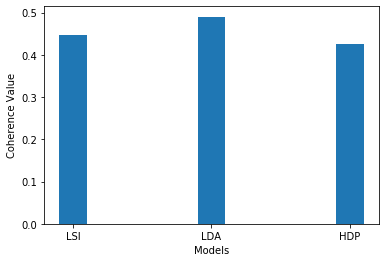

In [53]:
# Democrat
model_evaluation(lsi_dem, lda_dem, hdp_dem, dem_bigram, dem_lemmas)

In [54]:
# Republican
# model_evaluation(lsi_rep, lda_rep, hdp_rep, rep_bigram, rep_lemmas)

# Text Generation

In [9]:
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import re
import matplotlib

## Word Embeddings

In [17]:
ind_vect = Word2Vec(ind_tokens, window=3, size=300, workers=4, min_count=3,iter=500)
dem_vect = Word2Vec(dem_tokens, window=3, size=300, workers=4, min_count=3, iter=500)
rep_vect = Word2Vec(rep_tokens, window=3, size=300, workers=4, min_count=3, iter=500)

In [18]:
# How good is each party-vector embedding?
print(ind_vect.most_similar('congress', topn=5), '\n\n', 
      dem_vect.most_similar('congress', topn=5), '\n\n',
      rep_vect.most_similar('congress', topn=5))

[('big', 0.6902073621749878), ('important', 0.6569638252258301), ('forced', 0.6504098176956177), ('said', 0.5756253004074097), ('look', 0.5576599836349487)] 

 [('house', 0.5109204053878784), ('bill', 0.4339698553085327), ('committee', 0.39469119906425476), ('majority', 0.3682865500450134), ('think', 0.36376094818115234)] 

 [('house', 0.4060817062854767), ('bill', 0.3543917238712311), ('committee', 0.33553454279899597), ('legislation', 0.3193507790565491), ('would', 0.30283012986183167)]


# LSTM

In [99]:
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

### Creating model for Independent candidate speeches

In [100]:
embedding_layer = Embedding(input_dim=ind_vect.wv.vectors.shape[0], 
                            output_dim=ind_vect.wv.vectors.shape[1], 
                            weights=[ind_vect.wv.vectors])

model_ind = Sequential()

model_ind.add(embedding_layer)
model_ind.add(LSTM(ind_vect.wv.vectors.shape[1]))
model_ind.add(Dense(ind_vect.wv.vectors.shape[0]))   
model_ind.add(Activation('softmax'))
model_ind.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

### Creating model for Democratic candidate speeches

In [101]:
embedding_layer = Embedding(input_dim=dem_vect.wv.vectors.shape[0], 
                            output_dim=dem_vect.wv.vectors.shape[1], 
                            weights=[dem_vect.wv.vectors])

model_dem = Sequential()

model_dem.add(embedding_layer)
model_dem.add(LSTM(ind_vect.wv.vectors.shape[1]))
model_dem.add(Dense(ind_vect.wv.vectors.shape[0]))   
model_dem.add(Activation('softmax'))
model_dem.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

### Creating model for Republic candidate speeches

In [102]:
embedding_layer = Embedding(input_dim=rep_vect.wv.vectors.shape[0], 
                            output_dim=rep_vect.wv.vectors.shape[1], 
                            weights=[rep_vect.wv.vectors])

model_rep = Sequential()

model_rep.add(embedding_layer)
model_rep.add(LSTM(ind_vect.wv.vectors.shape[1]))
model_rep.add(Dense(ind_vect.wv.vectors.shape[0]))   
model_rep.add(Activation('softmax'))c
model_rep.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [103]:
model_ind.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         66300     
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_4 (Dense)              (None, 221)               66521     
_________________________________________________________________
activation_4 (Activation)    (None, 221)               0         
Total params: 854,021
Trainable params: 854,021
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_dem.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         3101100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_5 (Dense)              (None, 221)               66521     
_________________________________________________________________
activation_5 (Activation)    (None, 221)               0         
Total params: 3,888,821
Trainable params: 3,888,821
Non-trainable params: 0
_________________________________________________________________


In [105]:
model_rep.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         2564400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_6 (Dense)              (None, 221)               66521     
_________________________________________________________________
activation_6 (Activation)    (None, 221)               0         
Total params: 3,352,121
Trainable params: 3,352,121
Non-trainable params: 0
_________________________________________________________________


In [106]:
def word2idx(word,word_model):
    return word_model.wv.vocab[word].index

def idx2word(idx,word_model):
    return word_model.wv.index2word[idx]

In [107]:
pretrained_weights = ind_vect.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['congress']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist)
                           for similar, dist in ind_vect.wv.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

Result embedding shape: (221, 300)
Checking similar words:
  congress -> big (0.69), important (0.66), forced (0.64), said (0.57), look (0.56), vermont (0.51), legislation (0.50), agreements (0.44)


In [108]:
def sample(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_next(text, num_generated,word_vec,model):
    word_idxs = [word2idx(word,word_vec) for word in text.lower().split()]
    for i in range(num_generated):
        prediction = model.predict(x=np.array(word_idxs))
        idx = sample(prediction[-1], temperature=0.7)
        word_idxs.append(idx)
    return ' '.join(idx2word(idx,word_vec) for idx in word_idxs)

### Generate text for independent candidate speech on job

In [109]:
generate_next('job', 15,ind_vect,model_ind)

'job rich really legislation talked yes us ohio good-paying make got benefits aarp gap working debate'

### Generate text for democratic candidate speech on job cut

In [110]:
generate_next('job cut', 15,dem_vect,model_dem)

'job cut great substitute members commission workers safety americans process troops amendment 2 ask united see congressional'

### Generate text for republic candidate speech on job cut

In [111]:
generate_next('job cut', 15,rep_vect,model_rep)

'job cut within 1 congress since percent could families 2 leadership jurisdiction families military rights us billion'

## Model Evaluation

### We are using two techniques for evaluation our model :-
### 1. BLEU Score
### 2. ROUGE metric

### Sentence BLEU Score

To analyze the model performance,I have taken a sentence from the test dataset, which talks about job cut and I want to see what kind of text is produced by the model. It calculates individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

By default, the sentence_bleu() and corpus_bleu() scores calculate the cumulative 4-gram BLEU score, also called BLEU-4.
The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores.

In [120]:
reference =['job cut is something nobody would like to talk about and certainly nobody would like to encourage'.split()]
Candidate = generate_next('job cut', 15,rep_vect,model_rep)
candidate = Candidate.split()
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
score

2.2250738585072626e-308

### ROUGE (metric)
ROUGE, or Recall-Oriented Understudy for Gisting Evaluation is a set of metrics used for evaluating natural language processing output generated by a model. The metrics compare and produce summary of translated text against a reference or a set of references (human-produced) summary or translation.

ROUGE-N: Overlap of N-grams between the system and reference summaries.</br>
ROUGE-1 refers to the overlap of unigram (each word) between the system and reference summaries.</br>
ROUGE-2 refers to the overlap of bigrams between the system and reference summaries.</br>
ROUGE-l refers to  Longest Common Subsequence (LCS) based statistics. Longest common subsequence problem takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically.</br>

In [115]:
hypothesis = generate_next('job cut', 15,rep_vect,model_rep)

reference = "job cuts is something nobody would like to talk about and certainly nobody would like to encourage"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)
print(scores)

[{'rouge-1': {'f': 0.05882352441176514, 'p': 0.058823529411764705, 'r': 0.058823529411764705}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0689655122948874, 'p': 0.0625, 'r': 0.07692307692307693}}]
